In [954]:
from ddnn.nn import *
from ddnn.validation import *
from ddnn.data import *

estimator = Estimator(
    net=NeuralNetwork([
        LinearLayer((17, 4)),
        ActivationFunction("tanh"),
        LinearLayer((4, 1)),
        ActivationFunction("logistic")
    ]),
    loss=LossFunction("MSE"),
    # optimizer=Optimizer("SGD", learning_rate=0.3, momentum_coefficient=0.5, l2_coefficient=0),
    optimizer=Optimizer("Adam", learning_rate=1e-3, l2_coefficient=1e-3),
    batchsize=124,
    initializer=Initializer("glorot_uniform"),
)
early_stopping = None
epochs = 500
dataset_type = ("monk", 1)
# dataset_type = "ML_cup"
log_every = 1
losses = ["MSE", "binary_accuracy"]

In [955]:
if isinstance(dataset_type, tuple):
    traindata = read_monks(dataset_type[1], "train")
    traindata = onehot_encoding(data=traindata)

    testdata = read_monks(dataset_type[1], "test")
    testdata = onehot_encoding(data=testdata)
else:
    traindata, testdata = train_valid_split(read_ML_cup("train"), seed=123)

In [956]:
print(traindata.shape, testdata.shape)

(124, (17, 1)) (432, (17, 1))


In [957]:
testlogger = Logger(estimator, losses=losses, training_set=traindata, validation_set=testdata, every=log_every)
if early_stopping is not None:
    print("early stopping")
    teststopper = TrainingThresholdStopping(estimator, early_stopping)
    def callback(record):
        testlogger(record)
        teststopper(record)
else:
    def callback(record):
        testlogger(record)

In [958]:
estimator.train(traindata, callback=callback, n_epochs=epochs)

In [959]:
res = estimator.evaluate(losses=losses, dataset=traindata)
res

{'MSE': 0.006108237696163693, 'binary_accuracy': 1.0}

In [960]:
res = estimator.evaluate(losses=losses, dataset=testdata)
res

{'MSE': 0.008967907775822601, 'binary_accuracy': 1.0}

In [961]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from ipywidgets import interact

interactive(children=(Dropdown(description='loss', options=('MSE', 'binary_accuracy'), value='MSE'), Output())…

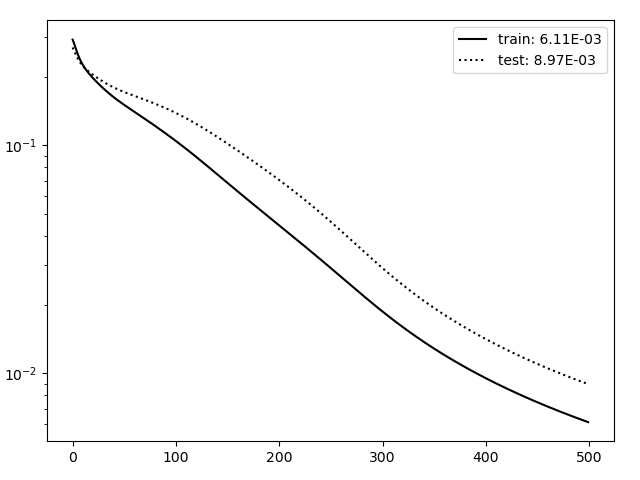

In [962]:
%matplotlib ipympl

# 1 plot with train and valid

fig, ax = plt.subplots()

@interact(
    loss = testlogger._losses,
)
def plot_results(loss):
    fig.tight_layout()
    ax.clear()
    for where, style in zip(["train", "valid"], [None, "dotted"]):
        y = testlogger._scores[0]["folds"][0][where][loss]
        if loss == "binary_accuracy":
            # todo fix to show last not best
            best = max(y)
            form = "{:.2}"
            logplot = False
        else:
            best = min(y)
            form = "{:.2E}"
            logplot = True
        # scale to resemble number of epochs instead of plot points
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*testlogger._every))
        ax.xaxis.set_major_formatter(ticks_x)
        if logplot:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
        if where == "valid":
            where = "test"
        ax.plot(y, label=f"{where}: {form.format(best)}", linestyle = style, color = "black")
        ax.legend()

In [963]:
n_tries = 10
train_loss_avg = {"MSE": 0, "binary_accuracy": 0}
test_loss_avg = {"MSE": 0, "binary_accuracy": 0}
for i in range(n_tries):
    estimator.reset()
    estimator.train(traindata, callback=lambda x: None, n_epochs=epochs)    
    train_res = estimator.evaluate(losses=losses, dataset=traindata)
    test_res = estimator.evaluate(losses=losses, dataset=testdata)
    print(train_res, test_res)
    for loss in losses:
        train_loss_avg[loss] += train_res[loss]
        test_loss_avg[loss] += test_res[loss]

for loss in losses:
    train_loss_avg[loss] = train_loss_avg[loss] / n_tries
    test_loss_avg[loss] = test_loss_avg[loss] / n_tries

{'MSE': 0.01166048370004711, 'binary_accuracy': 1.0} {'MSE': 0.01739006433649508, 'binary_accuracy': 1.0}
{'MSE': 0.010003787086531336, 'binary_accuracy': 1.0} {'MSE': 0.018489743491710713, 'binary_accuracy': 1.0}
{'MSE': 0.043115018740094525, 'binary_accuracy': 0.9435483870967742} {'MSE': 0.07861512146892569, 'binary_accuracy': 0.8842592592592593}
{'MSE': 0.012465623422813097, 'binary_accuracy': 1.0} {'MSE': 0.02097846382371912, 'binary_accuracy': 1.0}
{'MSE': 0.038248482703706996, 'binary_accuracy': 0.9758064516129032} {'MSE': 0.059838080565092794, 'binary_accuracy': 0.9444444444444444}
{'MSE': 0.022826678116428675, 'binary_accuracy': 0.9919354838709677} {'MSE': 0.037742386857919204, 'binary_accuracy': 0.9861111111111112}
{'MSE': 0.0380480134428203, 'binary_accuracy': 0.9516129032258065} {'MSE': 0.062245638152924755, 'binary_accuracy': 0.9166666666666666}
{'MSE': 0.06111767846818668, 'binary_accuracy': 0.9354838709677419} {'MSE': 0.08492172491133886, 'binary_accuracy': 0.916666666666

In [964]:
print(train_loss_avg)
print(test_loss_avg)

{'MSE': 0.02850821491651831, 'binary_accuracy': 0.9798387096774194}
{'MSE': 0.04849835536132477, 'binary_accuracy': 0.9557870370370372}
